In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import os.path
import sklearn.neural_network
import sklearn.svm
import sklearn.naive_bayes
import sklearn.tree
import lime.lime_tabular_mod
import lime.lime_tabular_multiregressor
import lime.lime_tabular_multiclassifier
import lime.lime_tabular_singleclassifier
import matplotlib.pyplot as plt
import doc.mod.utils.DatasetRepository as dr
import doc.mod.utils.ResultsProcessing as rp
from tqdm import tqdm

repo = dr.DatasetRepository("../data")


pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})





# Dataset: Titanic

In [2]:
labels_count = 2
bins_count = 30
version_str = "v3"
dataset_name = "Titanic"
dataset = repo.get_titanic_dataset(random_state=42)
dataset.train_data

,Pclass,Sex,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,embarked_unknown,cabin_level_A,cabin_level_B,cabin_level_C,cabin_level_D,cabin_level_E,cabin_level_F,cabin_level_G,cabin_level_T,cabin_level_unknown
PassengerId,,,,,,,,,,,,,,,,,,,
87,3,1,16.000000,1,3,34.3750,0,0,1,0,0,0,0,0,0,0,0,0,1
330,1,0,16.000000,0,1,57.9792,1,0,0,0,0,1,0,0,0,0,0,0,0
518,3,1,29.699118,0,0,24.1500,0,1,0,0,0,0,0,0,0,0,0,0,1
845,3,1,17.000000,0,0,8.6625,0,0,1,0,0,0,0,0,0,0,0,0,1
409,3,1,21.000000,0,0,7.7750,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,3,0,22.000000,0,0,7.7500,0,0,1,0,0,0,0,0,0,0,0,0,1
737,3,0,48.000000,1,3,34.3750,0,0,1,0,0,0,0,0,0,0,0,0,1
463,1,1,47.000000,0,0,38.5000,0,0,1,0,0,0,0,0,1,0,0,0,0







## Train different classifiers on the selected dataset (with their default settings)

In [ ]:
models = [
    ("Random Forest", sklearn.ensemble.RandomForestClassifier(n_jobs=-1)),
    ("AdaBoost", sklearn.ensemble.AdaBoostClassifier()),
    ("DecisionTree", sklearn.tree.DecisionTreeClassifier()),
    ("Neural Network", sklearn.neural_network.MLPClassifier()),
    # ("SVM", sklearn.svm.LinearSVC()), do not provide predict_proba
    ("Naive Bayes", sklearn.naive_bayes.GaussianNB()),
    ("kNN", sklearn.neighbors.KNeighborsClassifier())
]
precision_for_classifier = {}
recall_for_classifier = {}
f1_for_classifier = {}
for (classifier_name, model) in models:
    x = dataset.train_data.to_numpy()
    y = dataset.train_labels.to_numpy()
    model.fit(x, y)

    x = dataset.test_data.to_numpy()
    y_true = dataset.test_labels.to_numpy()
    y_predicted = model.predict(x)

    precision_for_classifier[classifier_name] = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_predicted, average="macro")
    recall_for_classifier[classifier_name] = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_predicted, average="macro")
    f1_for_classifier[classifier_name] = sklearn.metrics.f1_score(y_true=y_true, y_pred=y_predicted, average="macro")

test_data_subset = dataset.test_data.to_numpy()

test_instances_count = test_data_subset.shape[0]


In [ ]:
plt.figure(figsize=(14,4))
plt.bar(f1_for_classifier.keys(), f1_for_classifier.values(), width=0.5)
plt.title("f1_score")
plt.grid(axis="y")
plt.show()





## Use original LIME to explain classifiers' predictions

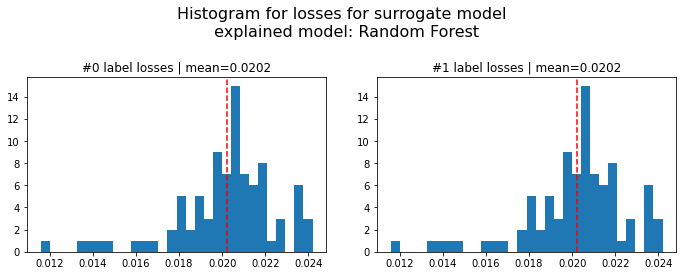

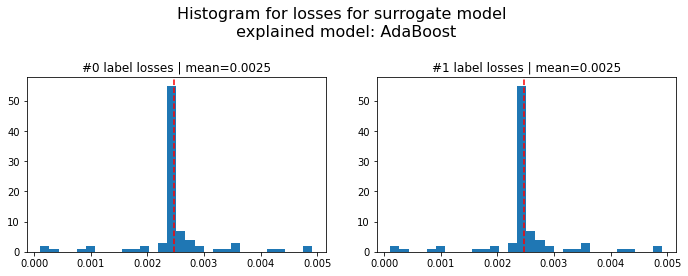

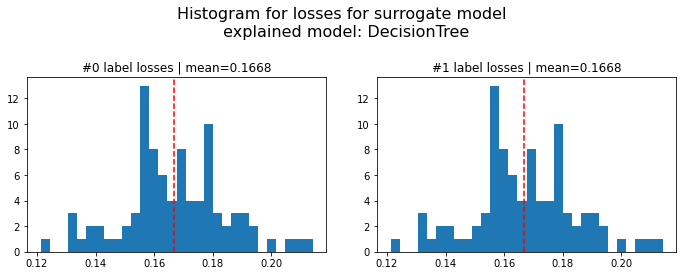

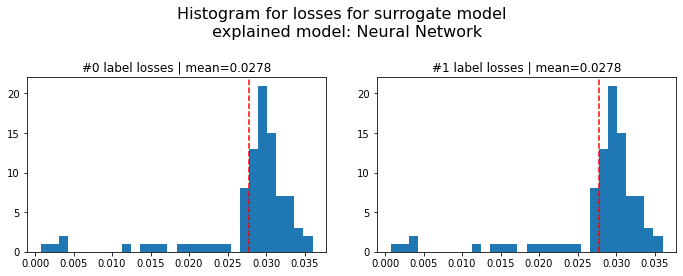

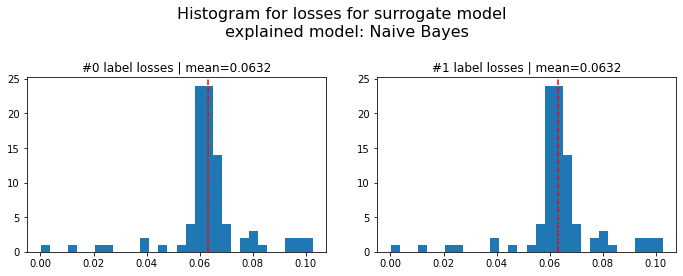

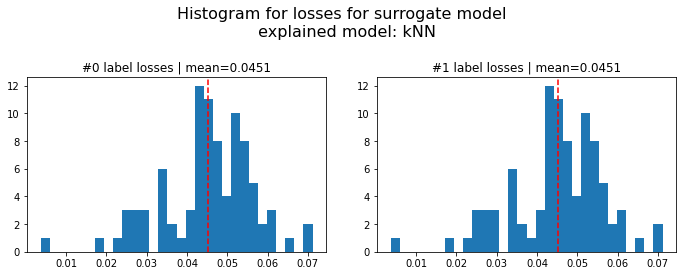

In [7]:
results_file_default = f"saved_results/{dataset_name}/default_results_{version_str}"
if os.path.isfile(results_file_default + ".npy"):
    postprocessor_default = rp.ResultsProcessing.from_file(
        results_file_default,
        models,
        labels_count
    )

else:
    scores_for_surrogate_model_default = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_for_surrogate_model_default = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_mean_for_cv_model_default = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_std_for_cv_model_default = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    fidelity_loss_on_explanation_default = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_generated_data_default = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_kfold_mean_default = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_kfold_std_default = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_distribution_quantiles_default = \
        np.empty(shape=(len(models), test_instances_count, bins_count), dtype="float32")

    for model_idx, (classifier_name, model) in enumerate(models):

        explainer_default = lime.lime_tabular_mod.LimeTabularExplainerMod(
            dataset.train_data.to_numpy(),
            feature_names = dataset.train_data.columns.to_list(),
            class_names = model.classes_,
            discretize_continuous=False,
            sample_around_instance=True,
            categorical_features=dataset.categorical_features,
            with_kfold=5
        )

        for instance_idx, test_instance in enumerate(tqdm(
                    test_data_subset,
                    desc=f"{classifier_name}",
                    bar_format="{desc:<20}{percentage:3.0f}%|{bar}{r_bar}"
        )):

            explanation = explainer_default.explain_instance(
                test_instance.reshape(-1),
                model.predict_proba,
                num_features = 4,
                top_labels = labels_count,
                distance_metric="minkowski",
                minkowski_norm=100.
            )
            scores_for_surrogate_model_default[model_idx, instance_idx, :] = \
                explanation.get_scores_for_surrogate_model()
            losses_for_surrogate_model_default[model_idx, instance_idx, :] = \
                explanation.get_losses_for_surrogate_model()
            losses_mean_for_cv_model_default[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="mean")
            losses_std_for_cv_model_default[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="std")
            fidelity_loss_on_explanation_default[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_explanation()
            fidelity_loss_on_generated_data_default[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_generated_data()
            fidelity_loss_on_kfold_mean_default[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_kfold(out="mean")
            fidelity_loss_on_kfold_std_default[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_kfold(out="std")
            fidelity_loss_distribution_quantiles_default[model_idx, instance_idx, :] = \
                explanation.get_fidelity_loss_distribution(quantiles=bins_count)

    postprocessor_default = rp.ResultsProcessing(
        models,
        labels_count,
        scores_for_surrogate_model_default,
        losses_for_surrogate_model_default,
        losses_mean_for_cv_model_default,
        losses_std_for_cv_model_default,
        fidelity_loss_on_explanation_default,
        fidelity_loss_on_generated_data_default,
        fidelity_loss_on_kfold_mean_default,
        fidelity_loss_on_kfold_std_default,
        fidelity_loss_distribution_quantiles_default
    )
    postprocessor_default.save_results(results_file_default)

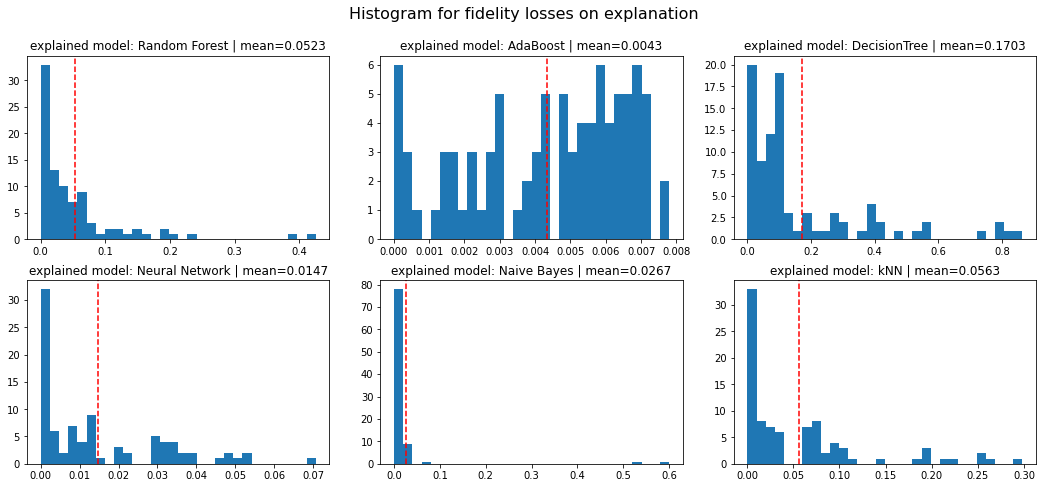

In [8]:
postprocessor_default.plot_scores_for_surrogate_model()

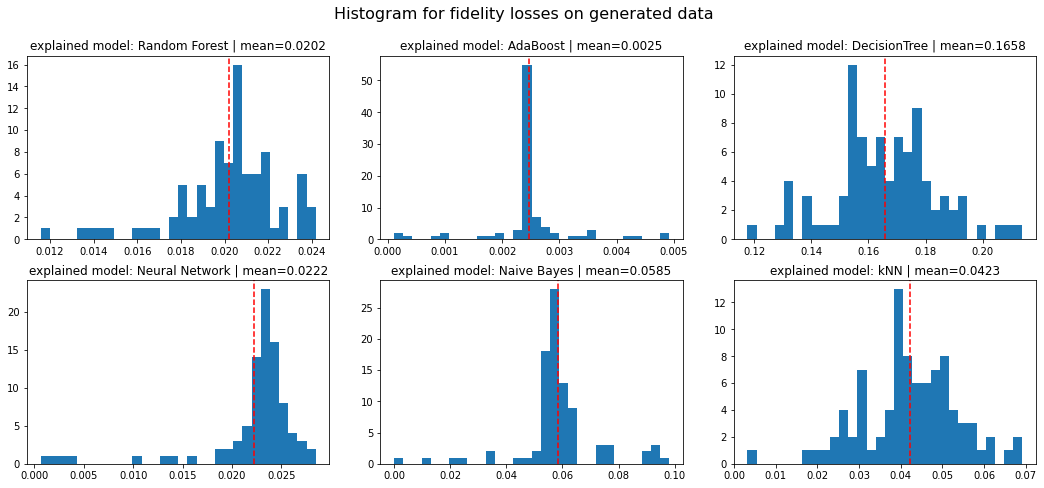

In [9]:
postprocessor_default.plot_losses_for_surrogate_model()

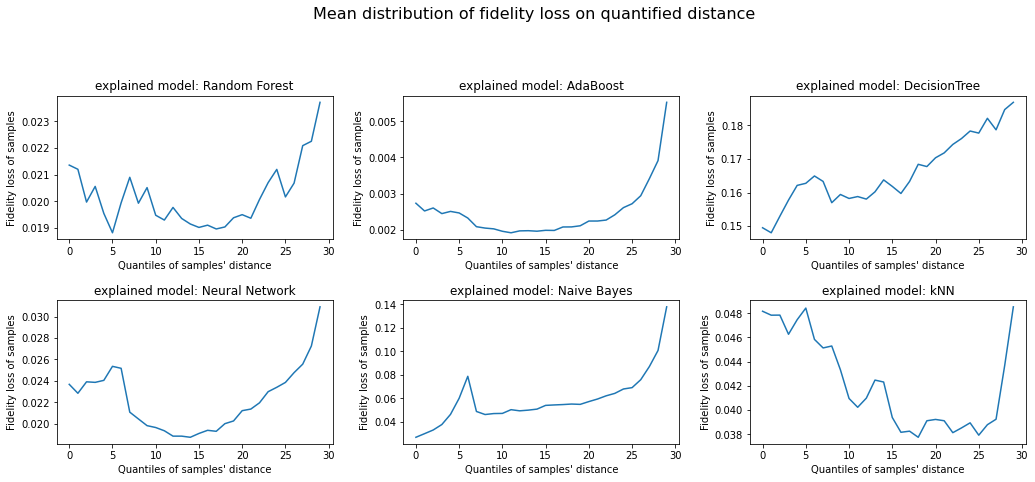

In [10]:
postprocessor_default.plot_fidelity_loss_on_explanation()

In [ ]:
postprocessor_default.plot_fidelity_losses_on_generated_data()

In [ ]:
postprocessor_default.plot_fidelity_loss_distribution(domain_unit="Quantiles")





## Use modified LIME to explain classifiers' predictions





### Use multiple Regression Trees as local surrogate

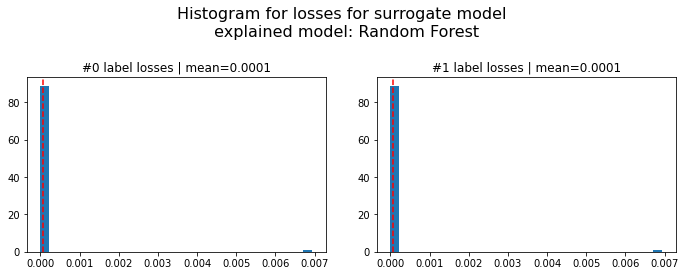

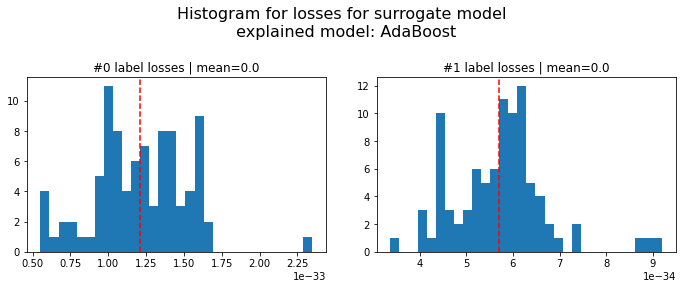

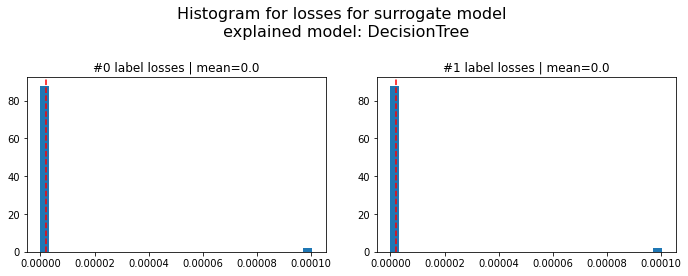

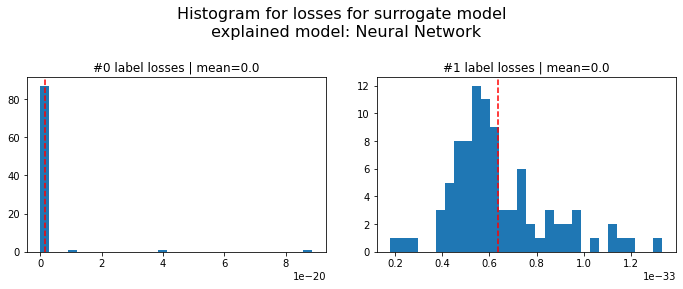

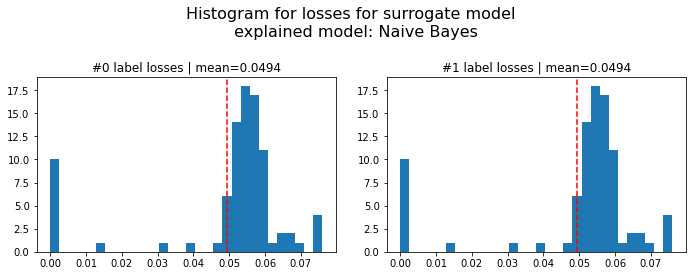

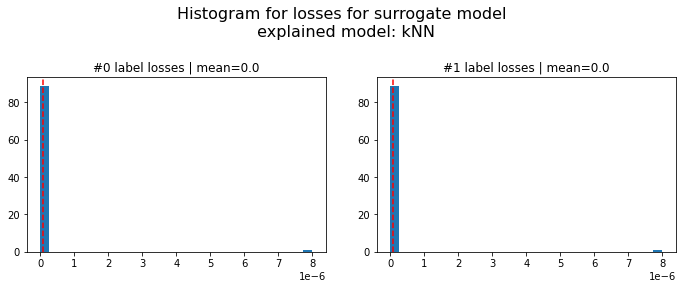

In [13]:
results_file_multiregression = f"saved_results/{dataset_name}/multiregression_results_{version_str}"
if os.path.isfile(results_file_multiregression + ".npy"):
    postprocessor_multiregression = rp.ResultsProcessing.from_file(
        results_file_multiregression,
        models,
        labels_count
    )

else:
    scores_for_surrogate_model_multiregression = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_for_surrogate_model_multiregression = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_mean_for_cv_model_multiregression = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_std_for_cv_model_multiregression = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    fidelity_loss_on_explanation_multiregression = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_generated_data_multiregression = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_kfold_mean_multiregression = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_kfold_std_multiregression = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_distribution_quantiles_multiregression = \
        np.empty(shape=(len(models), test_instances_count, bins_count), dtype="float32")

    for model_idx, (classifier_name, model) in enumerate(models):

        explainer_multiregression = lime.lime_tabular_multiregressor.LTEMultiRegressionTree(
            dataset.train_data.to_numpy(),
            feature_names = dataset.train_data.columns.to_list(),
            class_names = model.classes_,
            discretize_continuous=False,
            sample_around_instance=True,
            categorical_features=dataset.categorical_features,
            with_kfold=5
        )

        for instance_idx, test_instance in enumerate(tqdm(
                    test_data_subset,
                    desc=f"{classifier_name}",
                    bar_format="{desc:<20}{percentage:3.0f}%|{bar}{r_bar}"
        )):

            explanation = explainer_multiregression.explain_instance(
                test_instance.reshape(-1),
                model.predict_proba,
                num_features = 4,
                top_labels = labels_count,
                distance_metric="minkowski",
                minkowski_norm=100.
            )
            scores_for_surrogate_model_multiregression[model_idx, instance_idx, :] = \
                explanation.get_scores_for_surrogate_model()
            losses_for_surrogate_model_multiregression[model_idx, instance_idx, :] = \
                explanation.get_losses_for_surrogate_model()
            losses_mean_for_cv_model_multiregression[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="mean")
            losses_std_for_cv_model_multiregression[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="std")
            fidelity_loss_on_explanation_multiregression[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_explanation()
            fidelity_loss_on_generated_data_multiregression[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_generated_data()
            fidelity_loss_on_kfold_mean_multiregression[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_kfold(out="mean")
            fidelity_loss_on_kfold_std_multiregression[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_kfold(out="std")
            fidelity_loss_distribution_quantiles_multiregression[model_idx, instance_idx, :] = \
                explanation.get_fidelity_loss_distribution(quantiles=bins_count)

    postprocessor_multiregression = rp.ResultsProcessing(
        models,
        labels_count,
        scores_for_surrogate_model_multiregression,
        losses_for_surrogate_model_multiregression,
        losses_mean_for_cv_model_multiregression,
        losses_std_for_cv_model_multiregression,
        fidelity_loss_on_explanation_multiregression,
        fidelity_loss_on_generated_data_multiregression,
        fidelity_loss_on_kfold_mean_multiregression,
        fidelity_loss_on_kfold_std_multiregression,
        fidelity_loss_distribution_quantiles_multiregression
    )
    postprocessor_multiregression.save_results(results_file_multiregression)

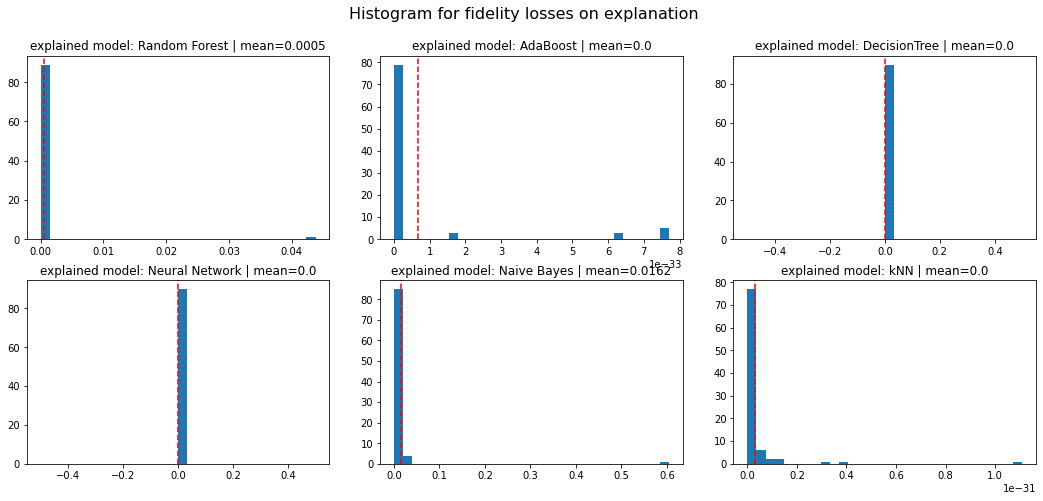

In [14]:
postprocessor_multiregression.plot_scores_for_surrogate_model()

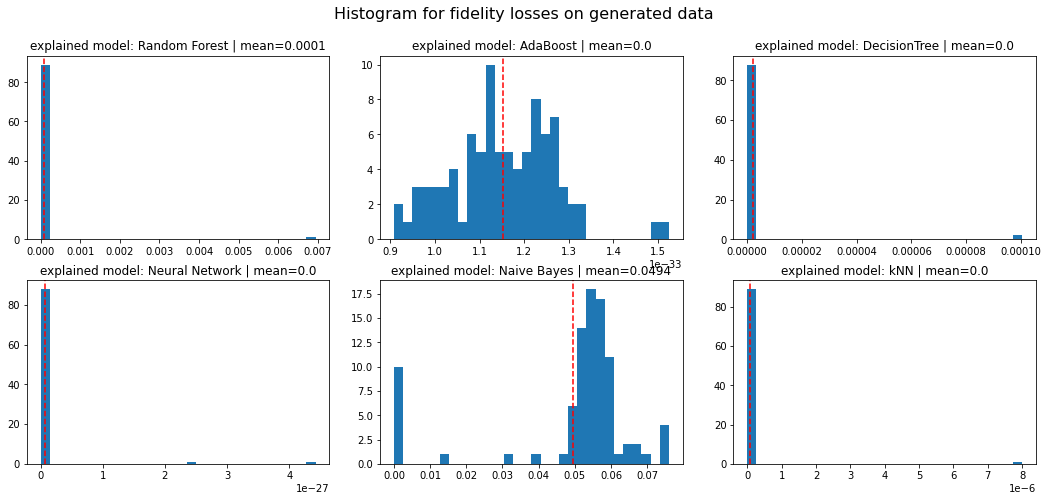

In [15]:
postprocessor_multiregression.plot_losses_for_surrogate_model()

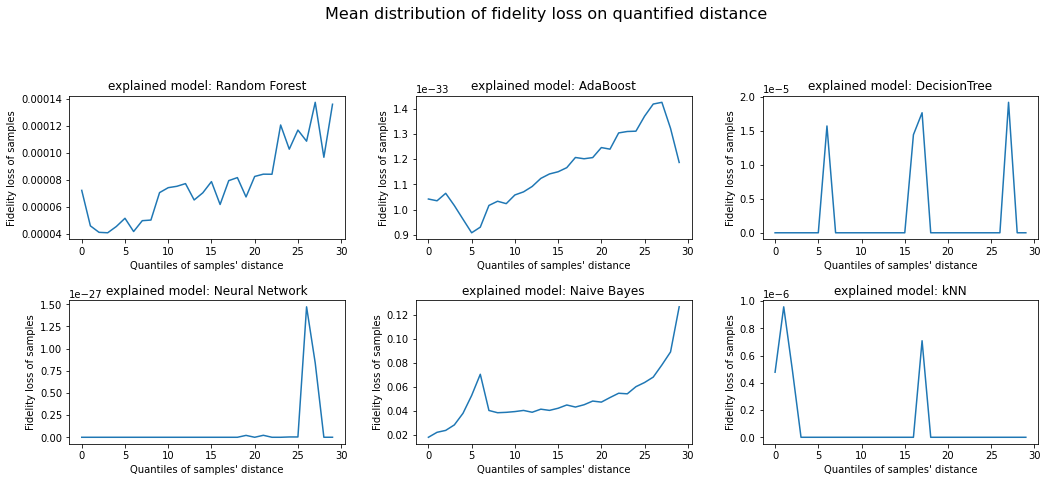

In [16]:
postprocessor_multiregression.plot_fidelity_loss_on_explanation()

In [17]:
postprocessor_multiregression.plot_fidelity_losses_on_generated_data()

In [ ]:
postprocessor_multiregression.plot_fidelity_loss_distribution(domain_unit="Quantiles")





### Use multiple Decision Trees as local surrogate

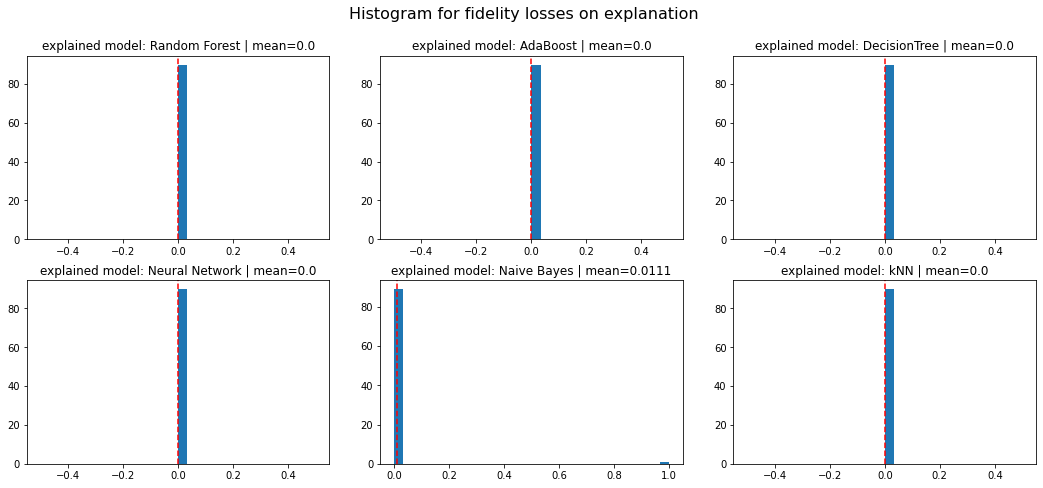

In [20]:
results_file_multiclassifier = f"saved_results/{dataset_name}/multiclassifier_results_{version_str}"
if os.path.isfile(results_file_multiclassifier + ".npy"):
    postprocessor_multiclassifier = rp.ResultsProcessing.from_file(
        results_file_multiclassifier,
        models,
        labels_count
    )

else:
    scores_for_surrogate_model_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_for_surrogate_model_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_mean_for_cv_model_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_std_for_cv_model_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    fidelity_loss_on_explanation_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_generated_data_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_kfold_mean_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_kfold_std_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_distribution_quantiles_multiclassifier = \
        np.empty(shape=(len(models), test_instances_count, bins_count), dtype="float32")

    for model_idx, (classifier_name, model) in enumerate(models):

        explainer_multiregression = lime.lime_tabular_multiclassifier.LTEMultiDecisionTree(
            dataset.train_data.to_numpy(),
            feature_names = dataset.train_data.columns.to_list(),
            class_names = model.classes_,
            discretize_continuous=False,
            sample_around_instance=True,
            categorical_features=dataset.categorical_features,
            with_kfold=5
        )

        for instance_idx, test_instance in enumerate(tqdm(
                    test_data_subset,
                    desc=f"{classifier_name}",
                    bar_format="{desc:<20}{percentage:3.0f}%|{bar}{r_bar}"
        )):

            explanation = explainer_multiregression.explain_instance(
                test_instance.reshape(-1),
                model.predict_proba,
                num_features = 4,
                top_labels = labels_count,
                distance_metric="minkowski",
                minkowski_norm=100.
            )
            scores_for_surrogate_model_multiclassifier[model_idx, instance_idx, :] = \
                explanation.get_scores_for_surrogate_model()
            losses_for_surrogate_model_multiclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_surrogate_model()
            losses_mean_for_cv_model_multiclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="mean")
            losses_std_for_cv_model_multiclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="std")
            fidelity_loss_on_explanation_multiclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_explanation()
            fidelity_loss_on_generated_data_multiclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_generated_data()
            fidelity_loss_on_kfold_mean_multiclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_kfold(out="mean")
            fidelity_loss_on_kfold_std_multiclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_kfold(out="std")
            fidelity_loss_distribution_quantiles_multiclassifier[model_idx, instance_idx, :] = \
                explanation.get_fidelity_loss_distribution(quantiles=bins_count)

    postprocessor_multiclassifier = rp.ResultsProcessing(
        models,
        labels_count,
        scores_for_surrogate_model_multiclassifier,
        losses_for_surrogate_model_multiclassifier,
        losses_mean_for_cv_model_multiclassifier,
        losses_std_for_cv_model_multiclassifier,
        fidelity_loss_on_explanation_multiclassifier,
        fidelity_loss_on_generated_data_multiclassifier,
        fidelity_loss_on_kfold_mean_multiclassifier,
        fidelity_loss_on_kfold_std_multiclassifier,
        fidelity_loss_distribution_quantiles_multiclassifier
    )
    postprocessor_multiclassifier.save_results(results_file_multiclassifier)

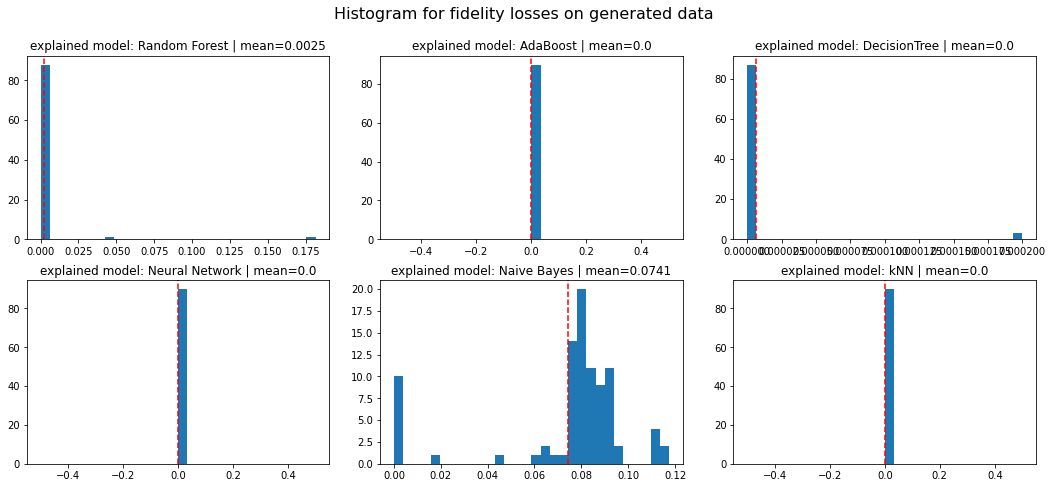

In [21]:
postprocessor_multiclassifier.plot_scores_for_surrogate_model()

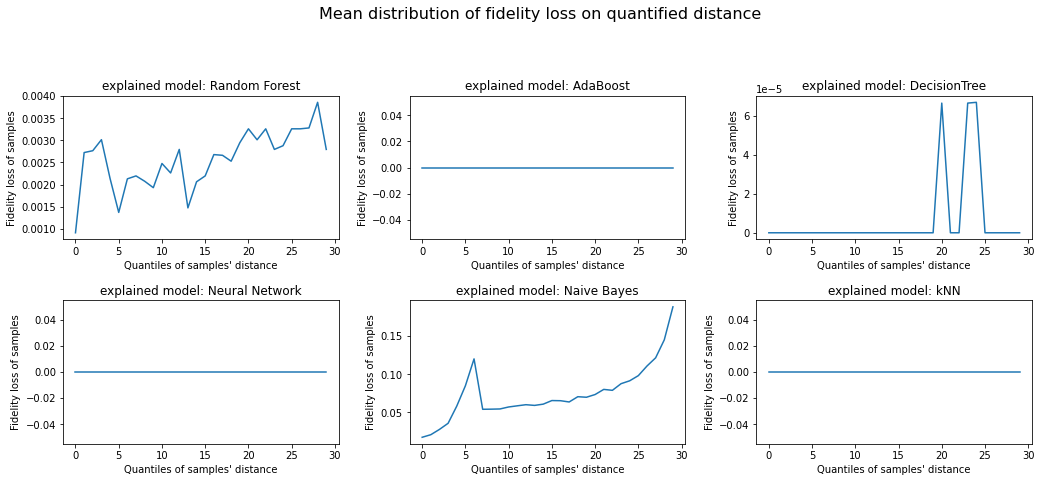

In [22]:
postprocessor_multiclassifier.plot_losses_for_surrogate_model()

In [ ]:
postprocessor_multiclassifier.plot_fidelity_loss_on_explanation()

In [23]:
postprocessor_multiclassifier.plot_fidelity_losses_on_generated_data()

kNN                 100%|██████████| 90/90 [00:47<00:00,  1.90it/s]


In [ ]:
postprocessor_multiclassifier.plot_fidelity_loss_distribution(domain_unit="Quantiles")





### Use single Decision Tree as local surrogate

In [ ]:
results_file_singleclassifier = f"saved_results/{dataset_name}/singleclassifier_results_{version_str}"
if os.path.isfile(results_file_singleclassifier + ".npy"):
    postprocessor_singleclassifier = rp.ResultsProcessing.from_file(
        results_file_singleclassifier,
        models,
        labels_count
    )

else:
    scores_for_surrogate_model_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_for_surrogate_model_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_mean_for_cv_model_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    losses_std_for_cv_model_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
    fidelity_loss_on_explanation_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_generated_data_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_kfold_mean_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_on_kfold_std_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count,), dtype="float32")
    fidelity_loss_distribution_quantiles_singleclassifier = \
        np.empty(shape=(len(models), test_instances_count, bins_count), dtype="float32")

    for model_idx, (classifier_name, model) in enumerate(models):

        explainer_multiregression = lime.lime_tabular_singleclassifier.LTESingleDecisionTree(
            dataset.train_data.to_numpy(),
            feature_names = dataset.train_data.columns.to_list(),
            class_names = model.classes_,
            discretize_continuous=False,
            sample_around_instance=True,
            categorical_features=dataset.categorical_features,
            with_kfold=5
        )

        for instance_idx, test_instance in enumerate(tqdm(
                    test_data_subset,
                    desc=f"{classifier_name}",
                    bar_format="{desc:<20}{percentage:3.0f}%|{bar}{r_bar}"
        )):

            explanation = explainer_multiregression.explain_instance(
                test_instance.reshape(-1),
                model.predict_proba,
                num_features = 4,
                top_labels = labels_count,
                distance_metric="minkowski",
                minkowski_norm=100.
            )
            scores_for_surrogate_model_singleclassifier[model_idx, instance_idx, :] = \
                explanation.get_scores_for_surrogate_model()
            losses_for_surrogate_model_singleclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_surrogate_model()
            losses_mean_for_cv_model_singleclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="mean")
            losses_std_for_cv_model_singleclassifier[model_idx, instance_idx, :] = \
                explanation.get_losses_for_cv_model(out="std")
            fidelity_loss_on_explanation_singleclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_explanation()
            fidelity_loss_on_generated_data_singleclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_generated_data()
            fidelity_loss_on_kfold_mean_singleclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_kfold(out="mean")
            fidelity_loss_on_kfold_std_singleclassifier[model_idx, instance_idx] = \
                explanation.get_fidelity_loss_on_kfold(out="std")
            fidelity_loss_distribution_quantiles_singleclassifier[model_idx, instance_idx, :] = \
                explanation.get_fidelity_loss_distribution(quantiles=bins_count)

    postprocessor_singleclassifier = rp.ResultsProcessing(
        models,
        labels_count,
        scores_for_surrogate_model_singleclassifier,
        losses_for_surrogate_model_singleclassifier,
        losses_mean_for_cv_model_singleclassifier,
        losses_std_for_cv_model_singleclassifier,
        fidelity_loss_on_explanation_singleclassifier,
        fidelity_loss_on_generated_data_singleclassifier,
        fidelity_loss_on_kfold_mean_singleclassifier,
        fidelity_loss_on_kfold_std_singleclassifier,
        fidelity_loss_distribution_quantiles_singleclassifier
    )
    postprocessor_singleclassifier.save_results(results_file_singleclassifier)

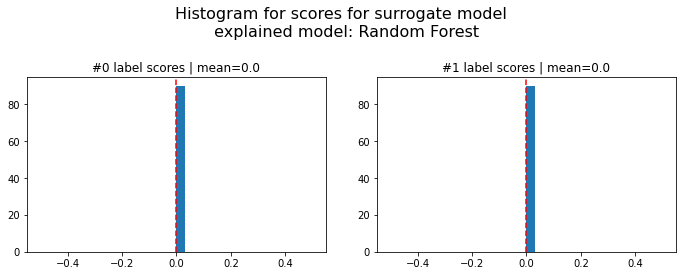

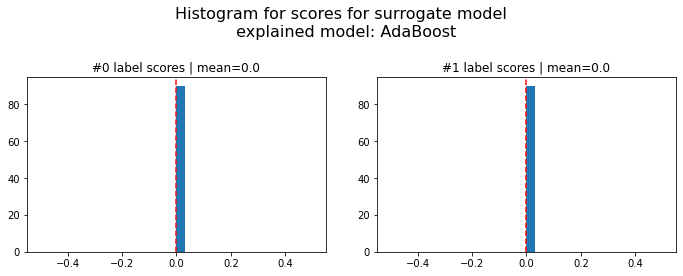

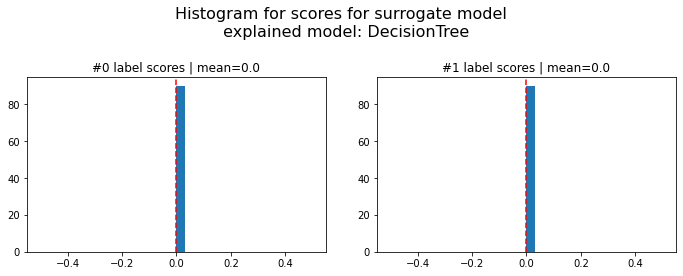

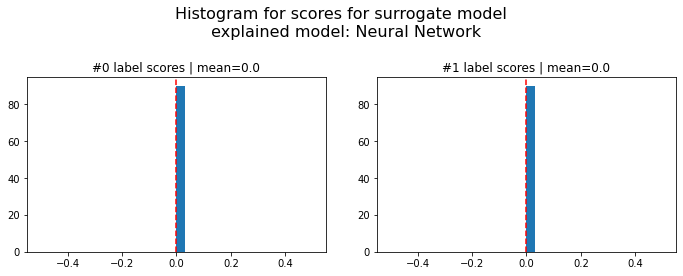

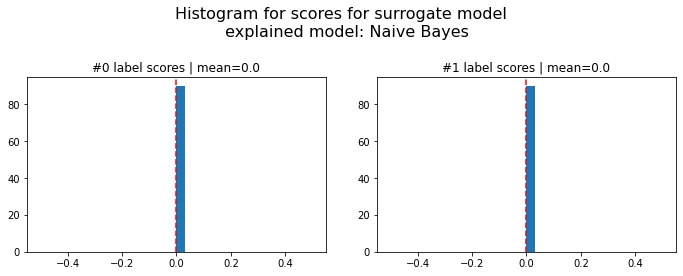

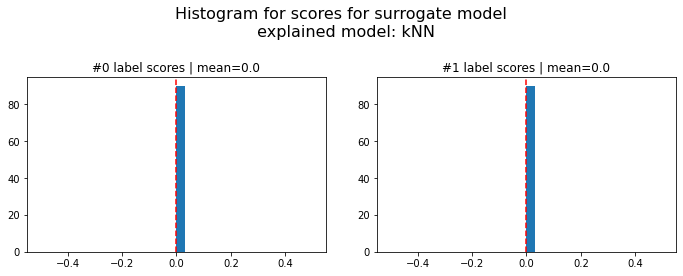

In [24]:
postprocessor_singleclassifier.plot_scores_for_surrogate_model()

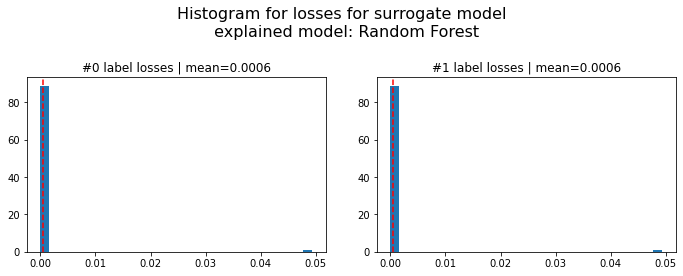

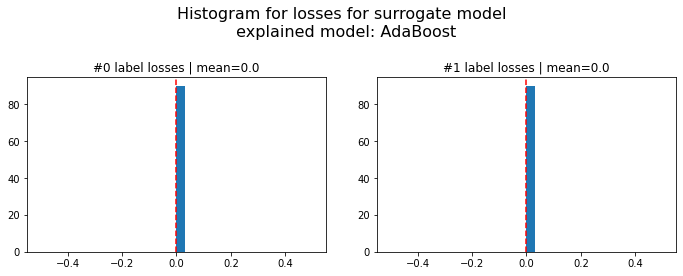

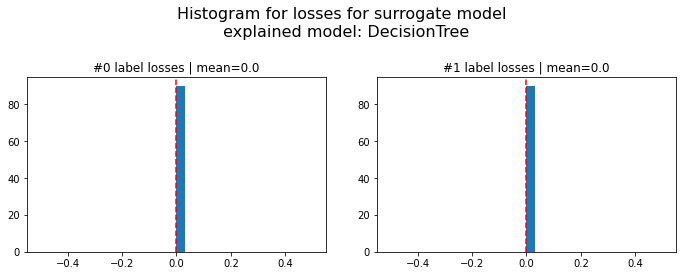

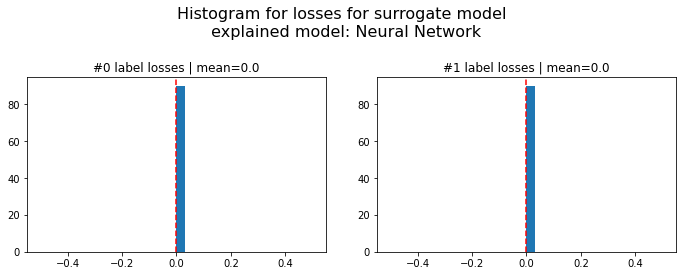

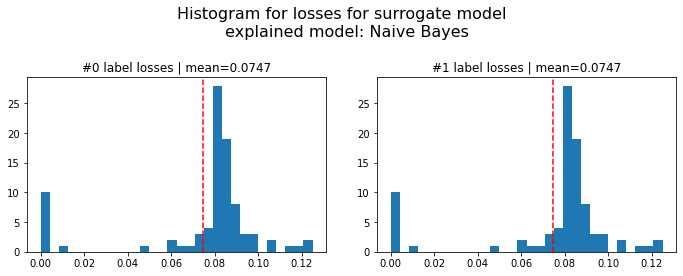

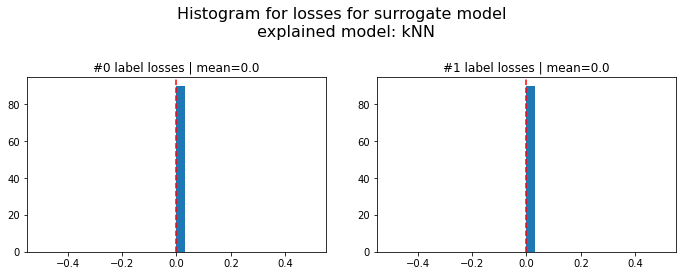

In [25]:
postprocessor_singleclassifier.plot_losses_for_surrogate_model()

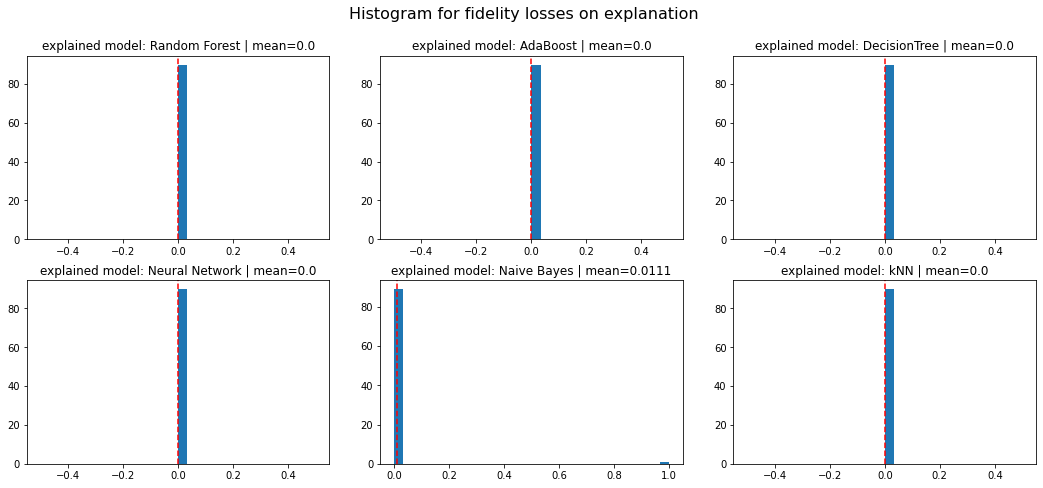

In [26]:
postprocessor_singleclassifier.plot_fidelity_loss_on_explanation()

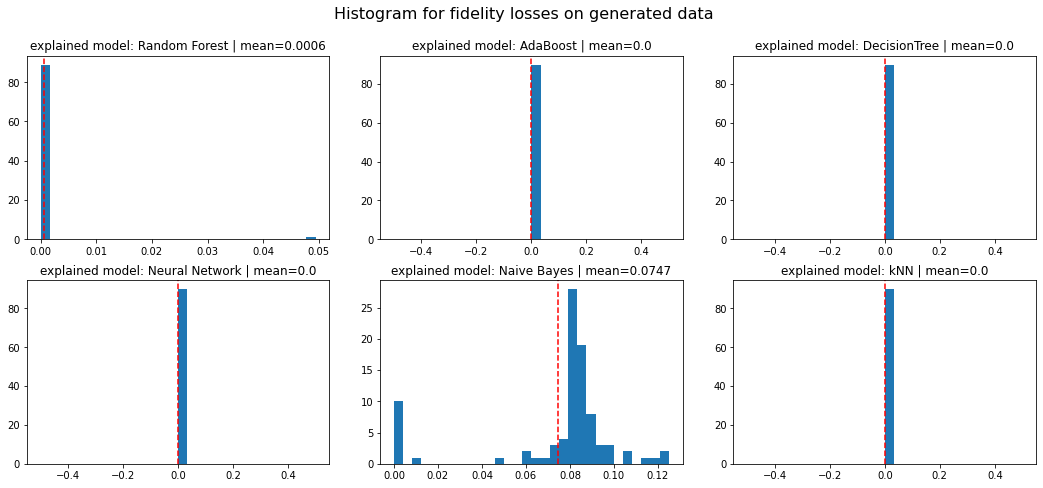

In [27]:
postprocessor_singleclassifier.plot_fidelity_losses_on_generated_data()

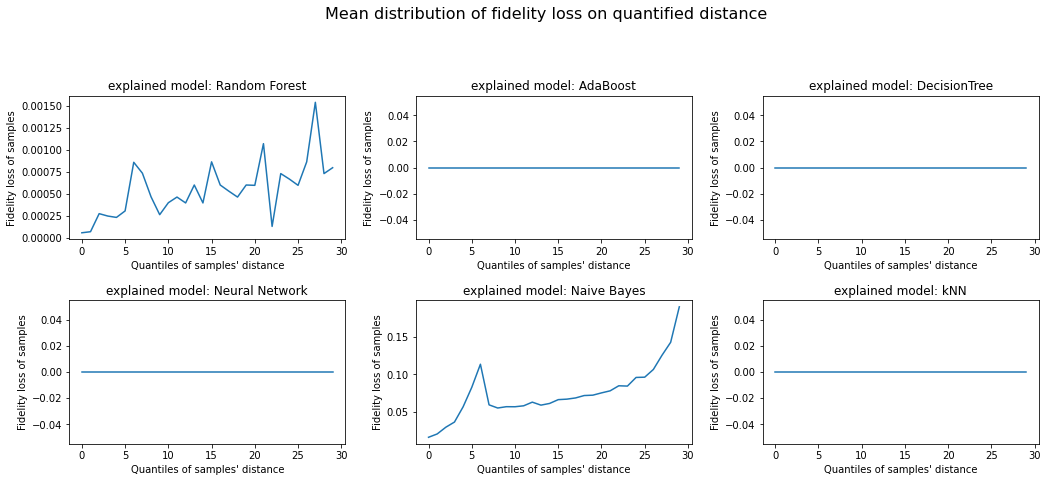

In [28]:
postprocessor_singleclassifier.plot_fidelity_loss_distribution(domain_unit="Quantiles")
